In [17]:
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import subprocess
import json
import os
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, auc, roc_curve
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from plotting import plot_confusion_matrix, plot_roc, plot_scores, plot_precision_recall, plot_feature_importance, plot_information_gain
from preprocessing import VandalismEncoder, RevisionGrouper, FeatureSelector
from undersampling import undersample_1_1, undersample_15_1, undersample_2_1, undersample_25_1, undersample_3_1, undersample_5_1, undersample_10_1
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
# Import dataset
df = pd.read_csv('./data/features-total-389dd98.csv', index_col='revision_id')
tag_df = pd.read_csv('./data/tag.csv', index_col='id')
df.head()

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,authorRank,authorRankOfLast200Edits,authorRankOneMonth,...,rawCommentLength,userCommentLength,hasNumericOutlierInColumns,hasNumericOutlierInRows,tableDataTypeInformationGain,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,tag_id
revision_id,,,,,,,,,,,,,,,,,,,,,
228189784,0.0,0.0,13.0,-1.0,7.0,-1.0,0.0,0.000000,0.000000,0.0,...,34.0,34.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,12
730449352,0.0,0.0,2.0,-1.0,2.0,-1.0,0.0,0.833333,0.857143,0.5,...,14.0,0.0,1.0,0.0,0.134129,0.0,0.0,0.0,0.0,12
216224416,0.0,0.0,17.0,-1.0,6.0,-1.0,1.0,0.000000,0.000000,0.0,...,67.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.0,0.0,12
539338621,0.0,1.0,1.0,-1.0,4.0,-1.0,1.0,0.000000,0.000000,0.0,...,152.0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,12
746191686,1.0,0.0,20.0,23.0,2.0,2.0,0.0,-1.000000,-1.000000,-1.0,...,10.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,12


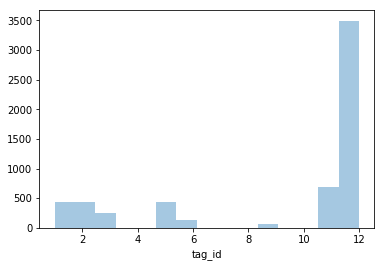

In [5]:
# Tag distribution
sns.distplot(df['tag_id'], kde=False)
plt.show()

In [6]:
BASELINE_FEATURE_COLUMNS = [
    # Context
    'isContributorAnonymous',
    'commentLength',
    'sizeChange',
    'timeSinceLastArticleEdit',
    'timeOfDay',
    'dayOfWeek',
    'timeSinceFirstArticleEditBySameContributor',
    'timeSinceContributorRevertedBeforeInThatArticle',
    'sizeRatio',
    'hasPreviousSameContributor',
    # Text
    'ratioOfNumericalCharsToAllChars',
    'ratioOfAlphanumericCharsToAllChars',
    'ratioOfUppercaseCharsToAllChars',
    'ratioOfUppercaseCharsToLowercaseChars',
    'lengthOfLongestConsecutiveSequenceOfSingleChar',
    'lengthOfLongestToken',
    'averageRelativeFrequencyOfNewAddedWords',
    'LZWCompressionRate',
    'KLDOfCharDistribution',
    'previousLength',
    # Language
    'vulgarWordFrequencyInComment',
    'vulgarWordFrequencyInTables',
    'vulgarWordImpactInTables',
    'personalPronounFrequencyInComment',
    'personalPronounFrequencyInTable',
    'personalPronounImpactInTable',
    # Ref: Colloquial, high bias
    'superlativeWordFrequencyInComment',
    'superlativeWordFrequencyInTable',
    'superlativeWordImpactInTable',
    'sexualWordFrequencyInComment',
    'sexualWordFrequencyInTables',
    'sexualWordImpactInTables',
    'averageAllBadWordFrequencyInComment',
    'averageAllBadWordFrequencyInTable',
    'averageAllBadWordImpactInTable',
    # Ref: Good words
    'wikiSyntaxElementFrequencyInTable',
    'wikiSyntaxElementImpactInTable',
    'wikiSyntaxElementFrequencyInComment',
    'revertInComment'
]

---
## Preprocessing

In [7]:
def preprocessing(features, tags):
    feature_columns = None
    selected_tags = []
    
    if features == 'baseline':
        feature_columns = BASELINE_FEATURE_COLUMNS
    
    if tags == 'all vandalism':
        selected_tags = [1, 2, 3, 5, 6, 9, 11]
    else:
        selected_tags.append(tags)

    preprocess_pipeline = Pipeline([
        ('vandalism_encoder', VandalismEncoder(selected_tags)),
        ('revision_grouper', RevisionGrouper()),
        ('feature_selector', FeatureSelector(feature_columns))
    ])

    print('Feature config:', features, 'Selected tags:', selected_tags)
    return preprocess_pipeline.transform(df)
    
widget = interactive(preprocessing, features=['all', 'baseline'], tags=['all vandalism', 1, 2, 3, 5, 6, 9, 11, 12])
display(widget)

interactive(children=(Dropdown(description='features', options=('all', 'baseline'), value='all'), Dropdown(des…

Feature config: all , Features after preprocessing: 90


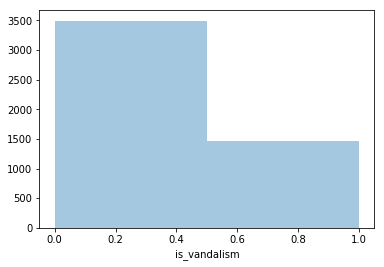

In [8]:
processed_df = widget.result
print('Feature config:', widget.kwargs['features'], ', Features after preprocessing:', len(processed_df.columns))

sns.distplot(processed_df['is_vandalism'].map(lambda x: 1 if x else 0), kde=False,  bins=2)
plt.show()

In [9]:
# X, y split
X = processed_df.drop(['is_vandalism'], axis=1)
y = processed_df['is_vandalism']

In [10]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X train', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)

X train (3723, 89)
y train (3723,)
X test (1242, 89)
y test (1242,)


---
## Grid search model parameters

In [23]:
# Grid search model params
parameters = [{
    'n_estimators': [500],
    'max_features': [0.5, 1.0],
    'ratio': [
        'majority',
        undersample_1_1,
        undersample_15_1,
        undersample_2_1,
        undersample_25_1,
        undersample_3_1,
        undersample_5_1,
        undersample_10_1
    ]
}]

# Custom scoring: Use only f1 of vandalism class
scores = {
    'f1_vandalism': make_scorer(f1_score, labels=[1], average=None),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'roc_auc': make_scorer(roc_auc_score)
}

grid_search = GridSearchCV(BalancedBaggingClassifier(DecisionTreeClassifier()),
                           parameters, 
                           scoring=scores,
                           refit='f1_vandalism',
                           cv=10,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

params = grid_search.best_params_
print('Best params', grid_search.best_params_)
print('Best score', grid_search.best_score_)

Best params {'n_estimators': 500, 'ratio': 'majority'}
Best score 0.6820080631505349


---
## Train: Cross evaluate model using best parameters

In [24]:
# Train scores & predictions
clf = BalancedBaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=params['n_estimators'],
                                ratio=params['ratio'],
                                max_features=params['max_features'],
                                n_jobs=-1)

train_scores = cross_validate(clf, X_train, y_train,
                        scoring=['f1', 'f1_micro', 'precision', 'recall', 'roc_auc', 'accuracy'],
                        cv=10, n_jobs=-1, return_train_score=False)

y_train_predict = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict')
y_train_predict_proba = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict_proba')

KeyboardInterrupt: 

In [ ]:
plot_scores(train_scores)

In [ ]:
plot_confusion_matrix(y_train, y_train_predict)

In [ ]:
plot_precision_recall(y_train, y_train_predict_proba[:, 1])

In [ ]:
plot_roc(y_train, y_train_predict_proba[:, 1])

In [ ]:
# Estimate feature importance with random forrest
clf = RandomForestClassifier(n_estimators=params['n_estimators'], n_jobs=-1)
clf.fit(X_train, y_train)
plot_feature_importance(clf, X_train.columns)

---
## Test: Test model on final test dataset

In [ ]:
clf = BalancedBaggingClassifier(DecisionTreeClassifier(),
                                n_estimators=params['n_estimators'],
                                max_features=params['max_features'],
                                ratio=params['ratio'],
                                n_jobs=-1)
clf.fit(X_train, y_train)

In [ ]:
y_test_predict = clf.predict(X_test)
y_test_predict_proba = clf.predict_proba(X_test)

In [ ]:
plot_confusion_matrix(y_test, y_test_predict)

In [ ]:
plot_precision_recall(y_test, y_test_predict_proba[:, 1])

In [ ]:
plot_roc(y_test, y_test_predict_proba[:, 1])

In [ ]:
# False positives for the test set
fp_test = X_test[(y_test == 0) & (y_test_predict == 1)]
fp_with_labels = fp_test.join(df, rsuffix='_original')
fp_with_labels[['tag_id']].head(10)

In [ ]:
# False negatives for the test set
fp_test = X_test[(y_test == 1) & (y_test_predict == 0)]
fp_with_labels = fp_test.join(df, rsuffix='_original')
fp_with_labels[['tag_id']].head(20)

In [ ]:
# Inspect revision
@interact(revision_id='', label=X.columns)
def show_revision(revision_id, label):
    if len(revision_id) > 1:
        print(df.loc[int(revision_id)][['tag_id', label]])

In [ ]:
# Feature histogramm
@interact(label=X.columns)
def show_feature_per_tag(label):
    sns.jointplot(x='tag_id', y=label, data=df)
    plt.show()
    print('Revisions with highest values')
    print(df.sort_values([label], ascending=[False])[['tag_id', label]].head(10))

In [ ]:
# Information Gain
plot_information_gain(X, y)